# Working with NOAA GFS data using Python



## Introduction to NOAA GFS Data

The NOAA Global Forecast System (GFS) is a weather forecast model predicting dozens of atmospheric and land-soil variables including temperatures, winds, and precipitation. The entire globe is covered by the GFS at a base horizontal resolution of 18 miles (28 kilometers) between grid points, which is used by the operational forecasters who predict weather out to 16 days in the future.

The data are stored on S3 in the bucket `s3://noaa-gfs-bdp-pds/` as grib2 files. 

In [1]:
import boto3
import cfgrib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
import numpy as np

Grib2 files also have a corresponding index file, often with a .idx suffix, that specify the included variables and their byte ranges in the file. We will take advantage of this to be able to do a range get to extract only the variables of interest.

In [2]:
gfs_bucket = 'noaa-gfs-bdp-pds'
gfs_time = ''
forecast_hour = 1
index_path = 'gfs.20191125/12/gfs.t12z.pgrb2.0p25.f001.idx'
grib_path = 'gfs.20191125/12/gfs.t12z.pgrb2.0p25.f001'

First we will download the index file and print it out so we can see all the variables included in the GFS. There are almost 400!

In [3]:
s3 = boto3.client('s3')
resp = s3.get_object(Bucket=gfs_bucket, Key=index_path)
index_data = resp['Body'].read().decode()
print(index_data)

1:0:d=2019112512:CLWMR:1 hybrid level:1 hour fcst:
2:22588:d=2019112512:ICMR:1 hybrid level:1 hour fcst:
3:118091:d=2019112512:RWMR:1 hybrid level:1 hour fcst:
4:173649:d=2019112512:SNMR:1 hybrid level:1 hour fcst:
5:190675:d=2019112512:GRLE:1 hybrid level:1 hour fcst:
6:199265:d=2019112512:REFC:entire atmosphere:1 hour fcst:
7:1053898:d=2019112512:VIS:surface:1 hour fcst:
8:2219656:d=2019112512:UGRD:planetary boundary layer:1 hour fcst:
9:2815319:d=2019112512:VGRD:planetary boundary layer:1 hour fcst:
10:3401968:d=2019112512:VRATE:planetary boundary layer:1 hour fcst:
11:3704784:d=2019112512:GUST:surface:1 hour fcst:
12:4307888:d=2019112512:HGT:0.4 mb:1 hour fcst:
13:4922596:d=2019112512:TMP:0.4 mb:1 hour fcst:
14:5235855:d=2019112512:ABSV:0.4 mb:1 hour fcst:
15:5606054:d=2019112512:O3MR:0.4 mb:1 hour fcst:
16:6499861:d=2019112512:HGT:1 mb:1 hour fcst:
17:7131701:d=2019112512:TMP:1 mb:1 hour fcst:
18:7493101:d=2019112512:RH:1 mb:1 hour fcst:
19:7493311:d=2019112512:UGRD:1 mb:1 hour fc

Now we will extract the range for the variable of interest. In this case we will extract the 500 hPa absolute vorticity. The index contains the byte range where the variable starts. To get the range that ends we have to look at the next variable in the list (or the total file size if it happens to be the last variable in the index).

In [4]:
variable = 'ABSV:500 mb:'
byte_start = 0
byte_end = 0
index_lines = index_data.split('\n')
var_indices = [i for i, s in enumerate(index_lines) if variable in s]
if len(var_indices) == 0:
    print("Your variable {} was not found in the index file!".format(variable))
if len(var_indices) > 1:
    print("Your variable {} was found multiple times in the index file. Try narrowing down your search!".format(variable))
index_start = var_indices[0]
index_end = index_start + 1
byte_start = index_lines[index_start].split(':')[1]
byte_end = index_lines[index_end].split(':')[1]
print("Variable {} starts at {} and ends at {}".format(variable, byte_start, byte_end))

Variable ABSV:500 mb: starts at 114754271 and ends at 115607685


Now that we have the ranges for just this variable, lets download it using a range get from S3.

In [5]:
resp = s3.get_object(Bucket=gfs_bucket, Key=grib_path, Range='bytes={}-{}'.format(byte_start, byte_end))
with open('var.grib', 'wb') as f:
    f.write(resp['Body'].read())

Now lets read the grib file using `cfgrib` and plot it as a figure.

In [6]:
ds = xr.open_dataset('var.grib', engine='cfgrib')
ds

Ignoring index file '/home/jovyan/var.grib.88a63.idx' older than GRIB file


<xarray.Dataset>
Dimensions:        (latitude: 721, longitude: 1440)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
    isobaricInhPa  int64 ...
  * latitude       (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time     datetime64[ns] ...
Data variables:
    absv           (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2019-11-25T20:10:47 GRIB to CDM+CF via cfgrib-0....

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


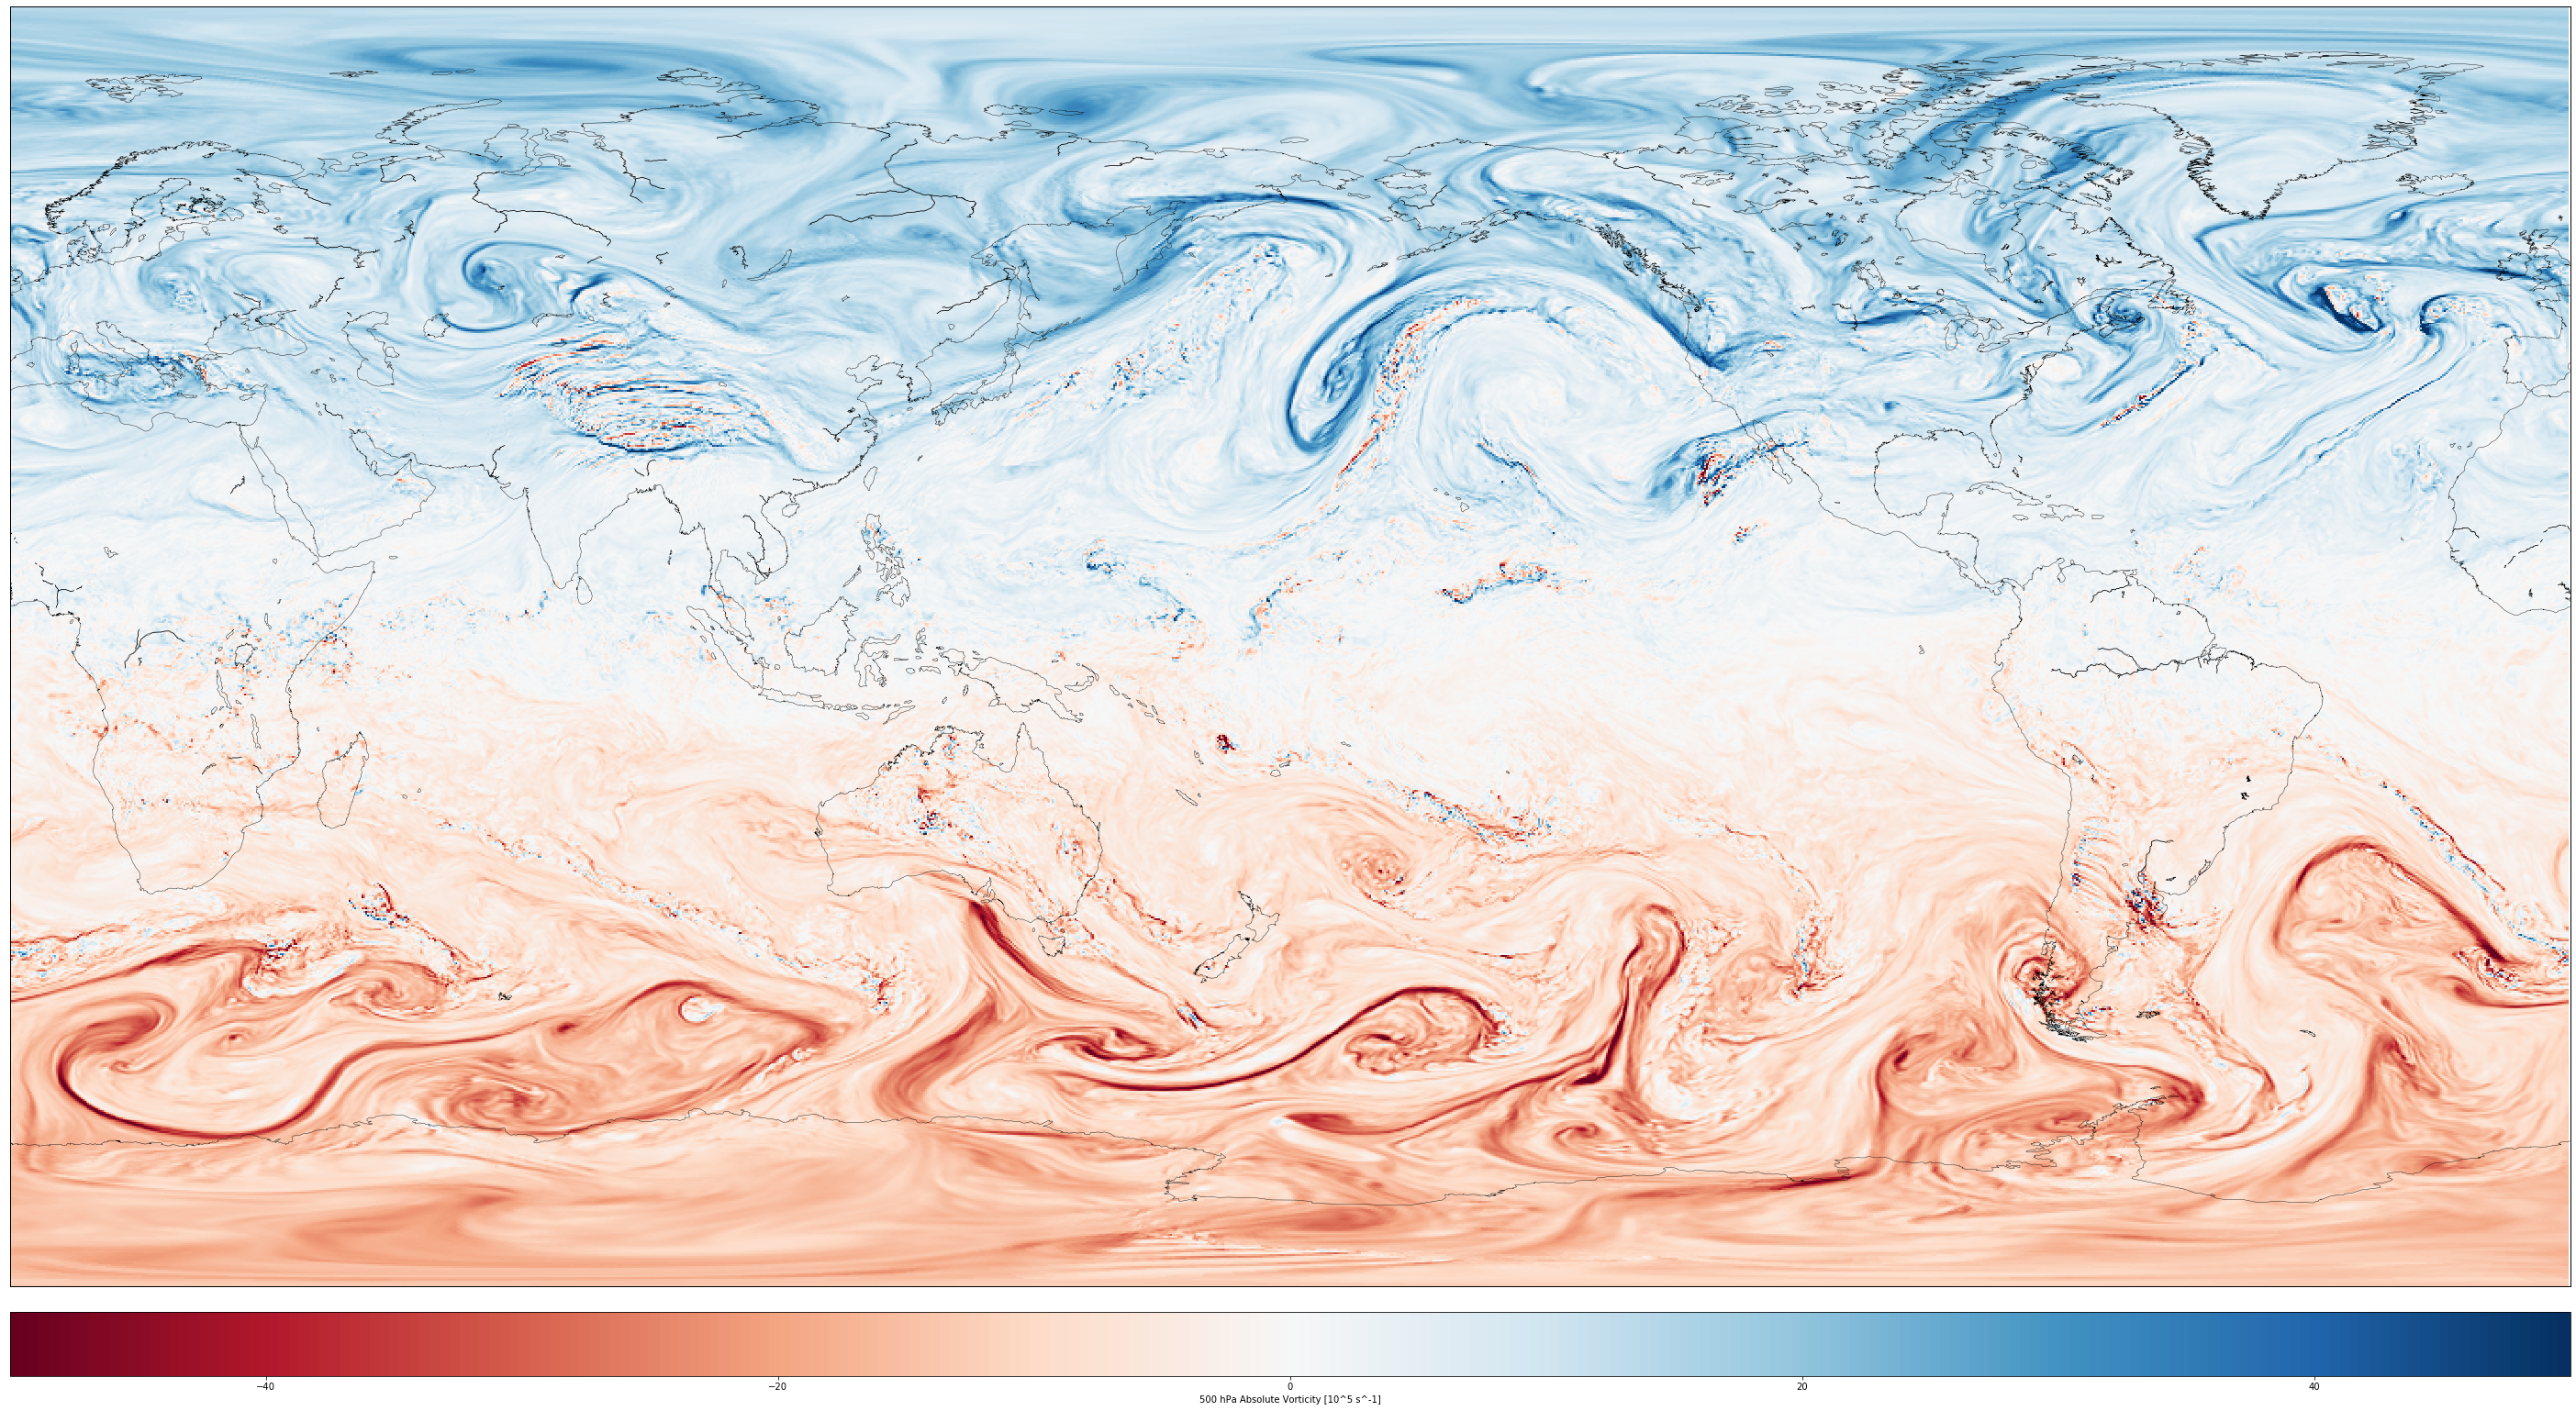

In [7]:
plt.subplots(figsize=(50,50))
m = Basemap(resolution='l', projection='cyl', lon_0=180.0, lat_0=0)
lon, lat = np.meshgrid(ds.longitude.data, ds.latitude.data)
xi, yi = m(lon, lat)

im = m.pcolormesh(xi, yi, ds.absv.values*10**5, cmap=plt.get_cmap("RdBu"), vmin = -50, vmax = 50)

m.drawmapboundary(fill_color='#ffffff')
m.drawcoastlines(color='#000000', linewidth=.4)

m.colorbar(location="bottom", label='500 hPa Absolute Vorticity [10^5 s^-1]')

plt.show()